# Fingerprint Siamese Neural Network 2.0

## Introduction

This is a Siamese Neural Network that compares the similarity between two unenhanced fingerpints. This model is similair to [Fingerprint Siamese Neural Network for Unenhanced Fingerprint Images (2/27/2023)](https://denkovarik.github.io/Fingerprint/Experiments/Fingerprint%20Siamese%20Neural%20Network%2020230227.html), which achieved a test accuracy of 93% on images of unenhanced fingerprints. The main difference with Fingerprint Siamese Neural Network 2.0 is that its network architecture modified to include more channels per layer. This was done in an attempt to help increase its performance and avoid overfitting. This would not only help the Siamese Neural Network compare the similarity between two fingerprints, but it would give the Fingerprint GAN more starting information about the fingerprint's structure if it was used to produce the initial latent vector. 

This Siamese Neural Network was adapted from https://github.com/kevinzakka/one-shot-siamese/blob/master/model.py for comparing images of characters. This model will be trained on a dataset of synthetically generated fringerprints using the [Anguli](https://dsl.cds.iisc.ac.in/projects/Anguli/) software.

This model was run from 3/07/2023 through 3/08/2023.


## Install Dependencies

In [1]:
!pip install Augmentor
!pip install pillow
!pip install seaborn
%reload_ext autoreload
%autoreload

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms.functional as Fv

import os
import time
import math
import random
import Augmentor
import numpy as np
import random
from numpy import unravel_index 
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from random import Random
from skimage.util import random_noise

from IPython.display import HTML
import matplotlib.animation as animation

## Config

In [3]:
model_results_file = "checkpoint/SSNN_results.pt"
model_ckpt_filename = "checkpoint/SSNN/SSNN_checkpoint"

im_size = (300, 206)
var_max = 0.5

num_train = 10000
num_valid = 4000
num_workers = 4
shuffle = True
augment = True

sim_label = 1.0
diff_label = 0.0

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of feature maps in Siamese Neural Network
ndf = 256

# Learning rate for optimizers
slr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

S_losses = []
iters = 0

num_epochs = 250

## Utils


In [4]:
def loadModel(filepath, netS, optimizerS, S_losses):
# Load checkpoint
    if os.path.isfile(filepath):
        checkpoint = torch.load(filepath)
        netS.load_state_dict(checkpoint['netS_state_dict'])
        optimizerS.load_state_dict(checkpoint['optimizerS_state_dict'])
        S_losses = checkpoint['S_losses']
        iters = checkpoint['iters']
        start_epoch = checkpoint['epoch']
        return netS, optimizerS, S_losses, iters, start_epoch
    return None

def saveCkpt(filepath, epoch, netS, optimizerS, S_losses, iters):
    if os.path.isfile(filepath):
        os.remove(filepath)
    torch.save({
        'epoch' : epoch,
        'netS_state_dict' : netS.state_dict(),
        'optimizerS_state_dict' : optimizerS.state_dict(),
        'S_losses' : S_losses,
        'iters' : iters,
    }, filepath)


def showSampleFingerprintPairs(test_loader):
    # Get a Batch of Sample Images
    batch = next(iter(test_loader))
    labels = batch[2][:8]

    # Display the Sample Images
    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(2,1,2)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.show()

    c = 0
    if labels is not None:
        for l in labels:
            if l == 1:
                print("     same     ", end="")
            else:
                print("     diff     ", end="")
            if c % 4 == 0:
                print(" ", end="")
            c += 1
            
        
def validate(epoch):
    # switch to evaluate mode
    netD.eval()

    correct = 0
    total = 0
    for i, (val_Im1, val_Im2, val_y) in enumerate(valid_loader):
        with torch.no_grad():
            variation = random.uniform(0,var_max)
            val_Im1 = torch.tensor(random_noise(val_Im1, mode='gaussian', mean=0, var=variation, clip=True), dtype=torch.float32)
            val_Im1, val_Im2, val_y = val_Im1.to(device), val_Im2.to(device), val_y.to(device)
            batch_size = val_Im1.shape[0]

            # compute log probabilities
            pred = torch.round(netD(val_Im1, val_Im2))
            correct += (pred == val_y).sum().item()
            total += batch_size
            if total > num_valid:
                break

        # compute acc and log
        valid_acc = (100. * correct) / total
        return valid_acc
    
                
class AverageMeter(object):
    """
    Computes and stores the average and
    current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class MovingAvg(object):
    """
    Computes the moving average of values
    """
    def __init__(self, length=10):
        self.length = length
        self.movingAvg = np.array([], dtype='f')
        
    def average(self):
        return np.average(self.movingAvg)
        
    def pop(self):
        if len(self.movingAvg > 0):
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
    
    def push(self, val):
        self.movingAvg = np.append(self.movingAvg, [val])
        if len(self.movingAvg) > self.length:
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
            


## Data Loader

In [5]:
def get_train_loader(target_dir, template_dir,
                           batch_size,
                           num_train,
                           num_valid,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=False):
    """
    Utility function for loading and returning train 
    iterator over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:10000]
    
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints, batch_size)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return (train_loader)



def get_train_valid_test_loaders(target_dir, template_dir,
                                 batch_size,
                                 num_train,
                                 num_valid,
                                 shuffle=False,
                                 num_workers=2,
                                 pin_memory=False):
    """
    Utility function for loading and returning train and valid 
    iterators over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    # Each unique Fingerprint is named as a number from 1 to 10,000 (10000 unique fingerprints)
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:7000]
    validation_prints = fingerprints[7000:9500]
    test_prints = fingerprints[9500:]
    
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints, batch_size)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # Get the Validation Dataloader 
    valid_dataset = FingerprintLoader(target_dir, template_dir, num_valid, validation_prints, batch_size)
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    
    # Get the Test Dataloader 
    test_dataset = FingerprintLoader(target_dir, template_dir, num_valid, test_prints, batch_size)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return (train_loader, valid_loader, test_loader)
    

class FingerprintLoader(Dataset):
    """
    This class is used to help load the fingerpint dataset.
    """
    def __init__(self, target_dataset, template_dataset, num_train, dataset, batch_size):
        """
        Initializes an instance for the FingerprintLoader class.

        :param self: instance of the FingerprintLoader class
        :param template_dataset: The template fingerprint dataset
        :param target_dataset: The second fingerprint dataset to match against 
                               the template dataset
        :param num_train: The number of images to load
        :param dataset: List of fingerprints to include in the set
        """
        super(FingerprintLoader, self).__init__()
        self.target_dataset = target_dataset
        self.template_dataset = template_dataset
        self.fingerprints_dataset = dataset
        self.num_train = num_train
        self.augment = augment
        self.batch_size = batch_size

    def __len__(self):
        """
        Helper function to return the length of the dataset

        :param self: instance of the FingerprintLoader class
        :return: the length of the dataset as an int
        """
        return self.num_train

    def __getitem__(self, index):
        """
        Getter function for accessing images from the dataset. This function will choose a 
        fingerprint image from the dataset and its corresponding enhanced fingerprint image.
        It will then preprocess the images before returning them.
        :param self: instance of the FingerprintLoader class
        :param index: index for data image in set to return
        :return: Image from dataset as a tensor
        """
        target_im_filepath, template_im_filepath, y = self.chooseFingerprintPair()
        targ_im = self.preprocessImage(target_im_filepath)
        temp_img = self.preprocessImage(template_im_filepath)
        y = torch.from_numpy(np.array([y], dtype=np.float32))
        return targ_im, temp_img, y
    
    
    def chooseFingerprintPair(self):
        """
        Returns the filepath of the target fingerprint image and the enhanced template fingerprint.
        :param self: instance of the FingerprintLoader class
        :return: The filepaths for the 
        """
        target_im_filepath = "targetim.jpg" 
        enhanced_target_im_filepath = "targetim.jpg"  
        y = float(random.randint(0,1))
        # Chose image
        while not os.path.isfile(target_im_filepath) or not os.path.isfile(template_im_filepath):
            target_im_filepath = self.target_dataset + random.choice(os.listdir(self.target_dataset))
            target_im_filepath +=  "/Impression_1/"
            target_im_name = random.choice(self.fingerprints_dataset)
            target_im_filepath = target_im_filepath + target_im_name + '.jpg'
            template_im_name = target_im_name
            if y < 0.9:
                while template_im_name == target_im_name:
                    template_im_name = random.choice(self.fingerprints_dataset)           
            template_im_filepath = self.template_dataset + random.choice(os.listdir(self.template_dataset)) \
                + "/Impression_1/" + template_im_name + '.jpg' 
        return target_im_filepath, template_im_filepath, y
    
    
    def preprocessImage(self, im_filepath):
        """
        Preprocesses the image. This function will open the image, convert 
        it to grayscale, pad the image in order to make is square, 
        normalize the image, and then finally convert it to a tensor.
        :param im: Filepath of the image to preprocess
        :return: The preprocessed image
        """
        im = Image.open(im_filepath)
        # Convert to Grayscale
        trans = transforms.Compose([#p.torch_transform(),
                                transforms.Resize(im_size),
                                transforms.Grayscale(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, )),
                              ])
        # Apply the transformations to the images and labels
        preprocessedImage = trans(im)
        return preprocessedImage

## Weight Initialization

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Siamese Neural Network

In [7]:
class SiameseNet(nn.Module):
    """
    A Convolutional Siamese Network for One-Shot Learning [1].
    Siamese networts learn image representations via a supervised metric-based
    approach. Once tuned, their learned features can be leveraged for one-shot
    learning without any retraining.
    References
    ----------
    https://github.com/kevinzakka/one-shot-siamese/blob/master/model.py
    - Koch et al., https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
    """
    def __init__(self):
        super(SiameseNet, self).__init__()

        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1, bias=False)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 1, bias=False)
        # Batch Norm Layers
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        self.bn4 = nn.BatchNorm2d(ndf * 16)
        # Fully Connected Layers
        self.fc1 = nn.Linear(1225, 512)
        self.fc2 = nn.Linear(805, 1)

    def sub_forward(self, x):
        """
        Forward pass the input image through 1 subnetwork.
        Args
        ----
        - x: Contains either the first or second image pair across the input batch.
        Returns
        -------
        - out: The hidden vector representation of the input vector x.
        """
        out = F.leaky_relu_(self.conv1(x), 0.2)
        out = F.leaky_relu_(self.bn1(self.conv2(out)), 0.2)
        out = F.leaky_relu_(self.bn2(self.conv3(out)), 0.2)
        out = F.leaky_relu_(self.bn3(self.conv4(out)), 0.2)
        out = self.conv5(out).view(out.shape[0], -1)
        return out

    def forward(self, x1, x2):
        """
        Forward pass the input image pairs through both subtwins. An image
        pair is composed of a left tensor x1 and a right tensor x2.
        Concretely, we compute the component-wise L1 distance of the hidden
        representations generated by each subnetwork, and feed the difference
        to a final fc-layer followed by a sigmoid activation function to
        generate a similarity score in the range [0, 1] for both embeddings.
        Args
        ----
        - x1: a Variable of size (B, C, H, W). The left image pairs along the
          batch dimension.
        - x2: a Variable of size (B, C, H, W). The right image pairs along the
          batch dimension.
        Returns
        -------
        - probas: a Variable of size (B, 1). A probability scalar indicating
          whether the left and right input pairs, along the batch dimension,
          correspond to the same class. We expect the network to spit out
          values near 1 when they belong to the same class, and 0 otherwise.
        """
        # encode image pairs
        h1 = self.sub_forward(x1)
        h2 = self.sub_forward(x2)

        # compute l1 distance
        diff = torch.abs(h1 - h2)
        
        # score the similarity between the 2 encodings
        scores = torch.sigmoid(self.fc2(diff))

        return scores

In [8]:
# Create the Siamese Neural Network
netS = SiameseNet().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netS = nn.DataParallel(netS, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netS.apply(weights_init)    

# Print the model
print(netS)

DataParallel(
  (module): SiameseNet(
    (conv1): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv3): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv4): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (conv5): Conv2d(2048, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=1225, out_features=512, bias=True)
    (fc2): Linear(in_features=805, out_features=1, bias=True)

## Training Round 1

The model will first be trained to match the enhanced fingerprint pair versions just as before. This will allow the subnetwork to learn how to extract the features from good quality fingerprints. 

### Set Training Params

In [9]:
# create data loaders
torch.manual_seed(1)
batch_size = 256

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': ngpu, 'pin_memory': True}
    
target_dir =   "/storage/Prepped_Fingerprints_206x300/Enhanced_Good/"
template_dir = "/storage/Prepped_Fingerprints_206x300/Enhanced_Good/"

# Create the dataloader
num_train = 100000
num_valid = 4000

data_loader = get_train_valid_test_loaders(target_dir, template_dir, batch_size, num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]
test_loader = data_loader[2]

criterion = nn.BCELoss()

slr = 0.0002

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))


### Data Visualization

It was difficult to get access to large enough fingerprint datasets for training. This is because fingerprints are considered personal information, so this data is not commonly avaiable to everyone. Because of this, I ended up having to synthetically generate my own dataset using the [Anguli](https://dsl.cds.iisc.ac.in/projects/Anguli/) software. This generated dataset contains close to one million fingerprint images of varying qualities, which includes around 10,000 unique fingerprints. 

Below are some sample images that the Fingerprint Siamese Neural Network will be trained on, which is a subset of the dataset containing around 100,000 enhanced images of the good quality synthetic fingerprints in the datase.


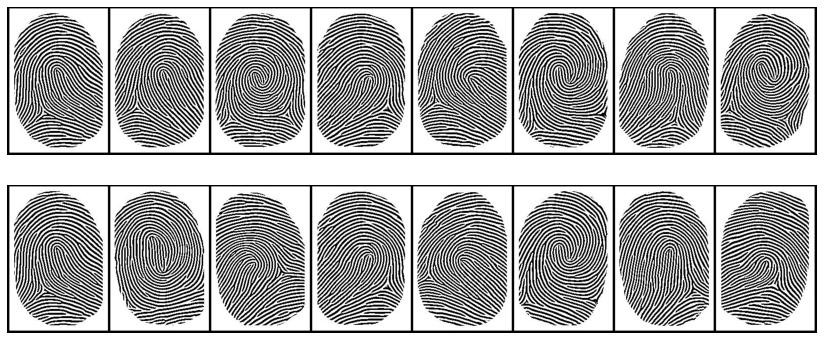

     same           diff          diff          same          diff           same          diff          diff     

In [10]:
showSampleFingerprintPairs(test_loader)

### Siamese Neural Network Training

In [14]:
# Train
def train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=[], num_epochs=10, start_epoch=1, end_epoch=num_epochs, iters=1):
    # Lists to keep track of progress
    iters = 0

    print("\n[*] Train on {} sample pairs, validate on {} sample pairs".format(
        num_train, num_valid)
    )

    gLossMvAvg = MovingAvg()

    for epoch in range(start_epoch, end_epoch+1):
        print('\nEpoch: {}/{}'.format(epoch, num_epochs)) 
        # switch to train mode
        netS.train()
        train_batch_time = AverageMeter()
        train_losses = AverageMeter()
        tic = time.time()
        training_accuracy = 0.0
        num_correct = 0
        total = 0
        with tqdm(total=num_train) as pbar:
            for i, (x1, x2, y) in enumerate(train_loader): 
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)
                output = netS(x1, x2).view(-1)
                y = y.view(-1)
                errS = criterion(output, y)
                # Calculate the gradients for this batch
                errS.backward()
                # Update S
                optimizerS.step()

                for i in range(len(output)):
                    label = 0.0
                    if output[i] > 0.5:
                        label = 1.0
                    if label == y[i]:
                        num_correct += 1
                    total += 1

                training_accuracy = num_correct / total * 100

                # store batch statistics
                toc = time.time()
                train_batch_time.update(toc-tic)
                tic = time.time()
                pbar.set_description(
                    (
                        "loss_S: {:.3f}   training accuracy: {:.6f}".format(errS.item(), training_accuracy)
                    )
                )
                pbar.update(batch_size)

                # Save Losses for plotting later
                S_losses.append(errS.item())
                iters +=1

        # Validate
        netS.eval()
        validation_accuracy = 0.0
        num_valid_correct = 0
        total_valid = 0
        for i, (x1, x2, y) in enumerate(valid_loader): 
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            output = netS(x1, x2).view(-1)
            y = y.view(-1)

            for i in range(len(output)):
                label = 0.0
                if output[i] > 0.5:
                    label = 1.0
                if label == y[i]:
                    num_valid_correct += 1
                total_valid += 1

        validation_accuracy = num_valid_correct / total_valid * 100
        print("Validataion Accuracy:  {:.6f}".format(validation_accuracy))
    
    filename = model_ckpt_filename + "_epochs_" + str(start_epoch) + "-" + str(end_epoch) + ".pt"
    saveCkpt(filename, 1, netS, optimizerS, S_losses, iters)  
    return S_losses, iters
        

In [12]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=1, end_epoch=1, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 1/250


loss_S: 0.189   training accuracy: 89.576000: : 100096it [07:45, 215.13it/s]                          


Validataion Accuracy:  99.475000


## Training Round 2

Next the model will be trained to match unenhanced good fingerprints to enhance fingerprint images. The hope is that this will help the network bridge the gap between matching enhanced fingerprint pairs to unenhanced fingerprint pairs.

### Set Training Params

In [10]:
# create data loaders
torch.manual_seed(1)
batch_size = 256

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': ngpu, 'pin_memory': True}
    
target_dir =   "/storage/Prepped_Fingerprints_206x300/Good/"
template_dir = "/storage/Prepped_Fingerprints_206x300/Enhanced_Good/"

# Create the dataloader
num_train = 100000
num_valid = 4000

data_loader = get_train_valid_test_loaders(target_dir, template_dir, batch_size, num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]
test_loader = data_loader[2]

criterion = nn.BCELoss()

slr = 0.00002

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))


### Data Visualization

Below are some sample images that the Fingerprint Siamese Neural Network will be trained on. The top row consists of the unenhanced good quality fingerprints, which is a subset of the dataset consisting of around 100,000 fingerprint images with 10,000 unique fingerprints. The bottom row consists of the enhanaced fingerprint images, which is a different subset of the dataset that also consists of around 100,000 fingerprint images containing the same 10,000 unique fingerprints as the perviously described subset. Please note that the enhanced fingerprint subset was generated from the unenhanced good fingerprint subset using Gabor Filters. 

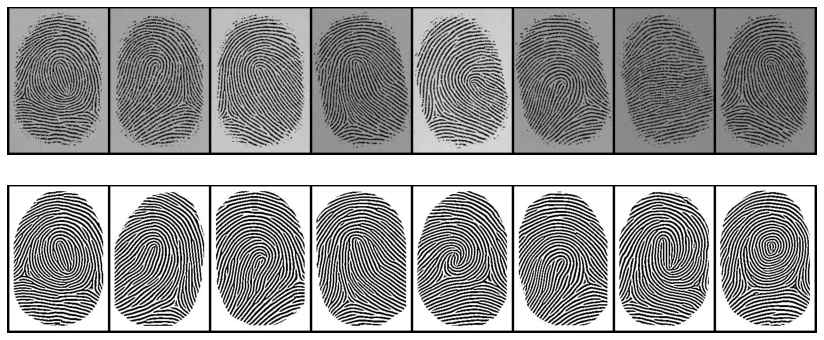

     same           diff          diff          same          diff           same          diff          diff     

In [14]:
showSampleFingerprintPairs(test_loader)

### Siamese Neural Network Training

Finally, the model will be trained to match unenhanced fingerprint pairs of varying qualities (from really good to really bad).

In [15]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=2, end_epoch=3, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 2/250


loss_S: 1.250   training accuracy: 98.128000: : 100096it [12:32, 132.95it/s]                         


Validataion Accuracy:  79.525000

Epoch: 3/250


loss_S: 0.625   training accuracy: 99.063000: : 100096it [13:54, 119.96it/s]                         


Validataion Accuracy:  88.600000


## Training Round 3

Finally, the model will be trained to match unenhanced fingerprint pairs of varying qualities (from really good to really bad).

### Set Training Params

In [11]:
# create data loaders
torch.manual_seed(1)
batch_size = 256

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': ngpu, 'pin_memory': True}
    
target_dir =   "/storage/Prepped_Fingerprints_206x300/Bad/"
template_dir = "/storage/Prepped_Fingerprints_206x300/Bad/"

# Create the dataloader
num_train = 100000
num_valid = 4000

data_loader = get_train_valid_test_loaders(target_dir, template_dir, batch_size, num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]
test_loader = data_loader[2]

criterion = nn.BCELoss()

slr = 0.000002

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.90))


### Data Visualization

Below are some sample images that the Fingerprint Siamese Neural Network will be trained on, which is a larger subset containing around 800,000 unenhanced fingerprint images of varying qualityies from really good to really bad.

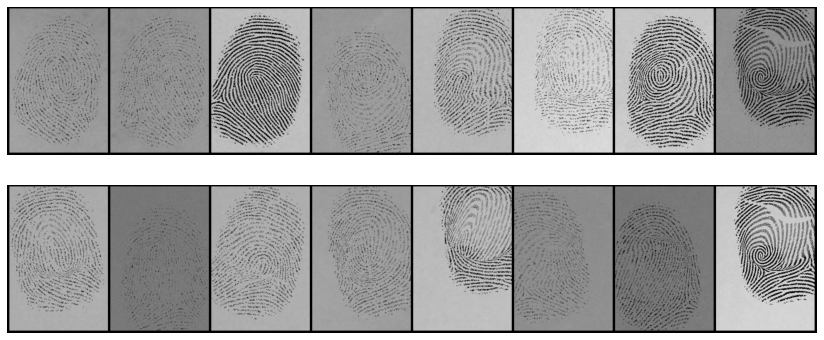

     same           diff          diff          same          diff           diff          diff          same     

In [17]:
showSampleFingerprintPairs(test_loader)

### Siamese Neural Network Training

In [18]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=4, end_epoch=10, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 4/250


loss_S: 36.214   training accuracy: 63.182000: : 100096it [20:45, 80.35it/s]                          


Validataion Accuracy:  63.800000

Epoch: 5/250


loss_S: 36.875   training accuracy: 62.144000: : 100096it [17:43, 94.11it/s]                          


Validataion Accuracy:  60.975000

Epoch: 6/250


loss_S: 35.643   training accuracy: 59.847000: : 100096it [08:24, 198.53it/s]                         


Validataion Accuracy:  60.050000

Epoch: 7/250


loss_S: 38.797   training accuracy: 57.197000: : 100096it [15:57, 104.54it/s]                         


Validataion Accuracy:  55.900000

Epoch: 8/250


loss_S: 47.527   training accuracy: 55.660000: : 100096it [16:42, 99.87it/s]                          


Validataion Accuracy:  53.575000

Epoch: 9/250


loss_S: 46.256   training accuracy: 54.591000: : 100096it [17:15, 96.67it/s]                          


Validataion Accuracy:  53.825000

Epoch: 10/250


loss_S: 51.758   training accuracy: 54.492000: : 100096it [17:20, 96.23it/s]                          


Validataion Accuracy:  54.975000


In [19]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=11, end_epoch=20, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 11/250


loss_S: 42.047   training accuracy: 55.901000: : 100096it [17:09, 97.18it/s]                          


Validataion Accuracy:  54.825000

Epoch: 12/250


loss_S: 41.875   training accuracy: 58.552000: : 100096it [16:35, 100.52it/s]                         


Validataion Accuracy:  60.300000

Epoch: 13/250


loss_S: 34.995   training accuracy: 61.959000: : 100096it [15:51, 105.18it/s]                         


Validataion Accuracy:  64.700000

Epoch: 14/250


loss_S: 40.045   training accuracy: 65.461000: : 100096it [15:49, 105.40it/s]                         


Validataion Accuracy:  66.950000

Epoch: 15/250


loss_S: 30.357   training accuracy: 67.476000: : 100096it [17:11, 97.06it/s]                          


Validataion Accuracy:  66.725000

Epoch: 16/250


loss_S: 35.690   training accuracy: 67.923000: : 100096it [20:37, 80.88it/s]                          


Validataion Accuracy:  68.700000

Epoch: 17/250


loss_S: 30.235   training accuracy: 68.256000: : 100096it [22:41, 73.53it/s]                          


Validataion Accuracy:  67.500000

Epoch: 18/250


loss_S: 28.061   training accuracy: 69.271000: : 100096it [19:50, 84.09it/s]                          


Validataion Accuracy:  69.025000

Epoch: 19/250


loss_S: 34.892   training accuracy: 69.457000: : 100096it [22:33, 73.93it/s]                          


Validataion Accuracy:  69.400000

Epoch: 20/250


loss_S: 31.453   training accuracy: 69.331000: : 100096it [25:29, 65.45it/s]                         


Validataion Accuracy:  68.525000


In [13]:
netS, optimizerS, S_losses, iters, start_epoch = loadModel('checkpoint/SSNN/SSNN_checkpoint_epochs_11-20.pt', netS, optimizerS, S_losses)

In [14]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=21, end_epoch=30, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 21/250


loss_S: 33.469   training accuracy: 70.438000: : 100096it [20:21, 81.95it/s]                          


Validataion Accuracy:  71.300000

Epoch: 22/250


loss_S: 32.988   training accuracy: 72.363000: : 100096it [20:41, 80.63it/s]                          


Validataion Accuracy:  72.250000

Epoch: 23/250


loss_S: 25.074   training accuracy: 71.873000: : 100096it [19:02, 87.63it/s]                          


Validataion Accuracy:  71.600000

Epoch: 24/250


loss_S: 28.897   training accuracy: 72.415000: : 100096it [18:11, 91.72it/s]                          


Validataion Accuracy:  73.100000

Epoch: 25/250


loss_S: 20.230   training accuracy: 74.574000: : 100096it [16:00, 104.21it/s]                         


Validataion Accuracy:  76.850000

Epoch: 26/250


loss_S: 19.942   training accuracy: 75.730000: : 100096it [06:01, 276.90it/s]                         


Validataion Accuracy:  75.825000

Epoch: 27/250


loss_S: 20.148   training accuracy: 76.836000: : 100096it [05:46, 289.02it/s]                         


Validataion Accuracy:  77.100000

Epoch: 28/250


loss_S: 23.430   training accuracy: 77.084000: : 100096it [05:26, 306.15it/s]                         


Validataion Accuracy:  78.375000

Epoch: 29/250


loss_S: 19.011   training accuracy: 77.989000: : 100096it [05:32, 301.20it/s]                         


Validataion Accuracy:  78.600000

Epoch: 30/250


loss_S: 19.189   training accuracy: 78.899000: : 100096it [05:35, 298.40it/s]                         


Validataion Accuracy:  79.125000


In [16]:
netS, optimizerS, S_losses, iters, start_epoch = loadModel('checkpoint/SSNN/SSNN_checkpoint_epochs_21-30.pt', netS, optimizerS, S_losses)

In [17]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=31, end_epoch=40, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 31/250


loss_S: 20.466   training accuracy: 79.977000: : 100096it [05:23, 309.86it/s]                         


Validataion Accuracy:  80.575000

Epoch: 32/250


loss_S: 16.385   training accuracy: 80.738000: : 100096it [05:26, 306.27it/s]                         


Validataion Accuracy:  81.025000

Epoch: 33/250


loss_S: 18.797   training accuracy: 81.552000: : 100096it [05:32, 300.89it/s]                         


Validataion Accuracy:  81.925000

Epoch: 34/250


loss_S: 14.595   training accuracy: 82.427000: : 100096it [05:22, 310.15it/s]                         


Validataion Accuracy:  81.900000

Epoch: 35/250


loss_S: 15.000   training accuracy: 82.986000: : 100096it [05:22, 310.72it/s]                         


Validataion Accuracy:  82.350000

Epoch: 36/250


loss_S: 13.506   training accuracy: 83.511000: : 100096it [05:24, 308.73it/s]                         


Validataion Accuracy:  83.350000

Epoch: 37/250


loss_S: 16.333   training accuracy: 83.902000: : 100096it [05:23, 309.29it/s]                         


Validataion Accuracy:  83.700000

Epoch: 38/250


loss_S: 13.047   training accuracy: 84.794000: : 100096it [05:22, 310.83it/s]                         


Validataion Accuracy:  85.350000

Epoch: 39/250


loss_S: 14.344   training accuracy: 85.245000: : 100096it [05:21, 311.05it/s]                         


Validataion Accuracy:  84.875000

Epoch: 40/250


loss_S: 9.889   training accuracy: 85.805000: : 100096it [05:27, 305.34it/s]                          


Validataion Accuracy:  85.925000


In [18]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=41, end_epoch=50, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 41/250


loss_S: 8.989   training accuracy: 86.570000: : 100096it [05:22, 310.17it/s]                          


Validataion Accuracy:  86.800000

Epoch: 42/250


loss_S: 9.176   training accuracy: 87.240000: : 100096it [05:21, 311.17it/s]                          


Validataion Accuracy:  87.475000

Epoch: 43/250


loss_S: 10.386   training accuracy: 87.891000: : 100096it [05:21, 310.95it/s]                         


Validataion Accuracy:  87.625000

Epoch: 44/250


loss_S: 13.173   training accuracy: 88.159000: : 100096it [05:21, 310.86it/s]                         


Validataion Accuracy:  87.925000

Epoch: 45/250


loss_S: 8.357   training accuracy: 88.391000: : 100096it [05:21, 310.96it/s]                          


Validataion Accuracy:  87.550000

Epoch: 46/250


loss_S: 9.389   training accuracy: 88.733000: : 100096it [05:23, 309.63it/s]                          


Validataion Accuracy:  88.950000

Epoch: 47/250


loss_S: 7.717   training accuracy: 88.800000: : 100096it [05:21, 311.07it/s]                          


Validataion Accuracy:  89.100000

Epoch: 48/250


loss_S: 9.920   training accuracy: 89.258000: : 100096it [06:22, 261.76it/s]                          


Validataion Accuracy:  89.275000

Epoch: 49/250


loss_S: 7.864   training accuracy: 89.398000: : 100096it [05:24, 308.63it/s]                          


Validataion Accuracy:  89.775000

Epoch: 50/250


loss_S: 7.658   training accuracy: 89.873000: : 100096it [05:47, 287.80it/s]                          


Validataion Accuracy:  89.600000


In [19]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=51, end_epoch=60, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 51/250


loss_S: 11.211   training accuracy: 90.049000: : 100096it [06:50, 244.04it/s]                         


Validataion Accuracy:  89.475000

Epoch: 52/250


loss_S: 8.369   training accuracy: 90.210000: : 100096it [06:07, 272.62it/s]                          


Validataion Accuracy:  89.725000

Epoch: 53/250


loss_S: 6.077   training accuracy: 90.503000: : 100096it [05:22, 310.85it/s]                          


Validataion Accuracy:  89.875000

Epoch: 54/250


loss_S: 7.406   training accuracy: 90.932000: : 100096it [05:24, 308.30it/s]                          


Validataion Accuracy:  91.600000

Epoch: 55/250


loss_S: 4.744   training accuracy: 91.019000: : 100096it [05:21, 310.91it/s]                          


Validataion Accuracy:  91.025000

Epoch: 56/250


loss_S: 4.611   training accuracy: 91.048000: : 100096it [05:22, 310.84it/s]                          


Validataion Accuracy:  91.450000

Epoch: 57/250


loss_S: 4.452   training accuracy: 91.135000: : 100096it [05:21, 311.02it/s]                          


Validataion Accuracy:  91.175000

Epoch: 58/250


loss_S: 7.368   training accuracy: 91.386000: : 100096it [05:21, 311.02it/s]                          


Validataion Accuracy:  91.775000

Epoch: 59/250


loss_S: 9.203   training accuracy: 91.564000: : 100096it [05:22, 310.84it/s]                          


Validataion Accuracy:  91.125000

Epoch: 60/250


loss_S: 6.125   training accuracy: 91.706000: : 100096it [05:23, 309.82it/s]                          


Validataion Accuracy:  91.925000


In [20]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=61, end_epoch=70, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 61/250


loss_S: 4.448   training accuracy: 91.628000: : 100096it [05:21, 311.15it/s]                          


Validataion Accuracy:  91.800000

Epoch: 62/250


loss_S: 5.502   training accuracy: 91.802000: : 100096it [05:21, 311.02it/s]                          


Validataion Accuracy:  91.600000

Epoch: 63/250


loss_S: 2.770   training accuracy: 92.108000: : 100096it [05:21, 311.14it/s]                          


Validataion Accuracy:  92.250000

Epoch: 64/250


loss_S: 7.341   training accuracy: 92.367000: : 100096it [05:21, 311.05it/s]                          


Validataion Accuracy:  92.650000

Epoch: 65/250


loss_S: 4.255   training accuracy: 92.300000: : 100096it [05:21, 310.90it/s]                          


Validataion Accuracy:  91.950000

Epoch: 66/250


loss_S: 6.474   training accuracy: 92.281000: : 100096it [05:25, 307.69it/s]                          


Validataion Accuracy:  92.775000

Epoch: 67/250


loss_S: 4.006   training accuracy: 92.253000: : 100096it [05:33, 300.22it/s]                          


Validataion Accuracy:  92.550000

Epoch: 68/250


loss_S: 6.019   training accuracy: 92.309000: : 100096it [05:23, 309.52it/s]                          


Validataion Accuracy:  92.025000

Epoch: 69/250


loss_S: 3.988   training accuracy: 92.626000: : 100096it [05:25, 307.33it/s]                          


Validataion Accuracy:  93.100000

Epoch: 70/250


loss_S: 6.644   training accuracy: 92.541000: : 100096it [05:22, 310.75it/s]                          


Validataion Accuracy:  91.875000


In [21]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=71, end_epoch=80, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 71/250


loss_S: 7.824   training accuracy: 92.673000: : 100096it [05:22, 310.69it/s]                         


Validataion Accuracy:  92.325000

Epoch: 72/250


loss_S: 6.976   training accuracy: 92.817000: : 100096it [05:24, 308.85it/s]                          


Validataion Accuracy:  93.450000

Epoch: 73/250


loss_S: 1.931   training accuracy: 93.108000: : 100096it [05:22, 310.14it/s]                         


Validataion Accuracy:  92.900000

Epoch: 74/250


loss_S: 5.358   training accuracy: 93.318000: : 100096it [05:21, 311.07it/s]                          


Validataion Accuracy:  93.575000

Epoch: 75/250


loss_S: 3.182   training accuracy: 93.234000: : 100096it [05:21, 311.24it/s]                         


Validataion Accuracy:  93.900000

Epoch: 76/250


loss_S: 4.595   training accuracy: 93.418000: : 100096it [05:26, 306.58it/s]                         


Validataion Accuracy:  93.950000

Epoch: 77/250


loss_S: 4.234   training accuracy: 93.554000: : 100096it [05:22, 310.76it/s]                         


Validataion Accuracy:  93.900000

Epoch: 78/250


loss_S: 2.491   training accuracy: 93.640000: : 100096it [05:21, 310.89it/s]                         


Validataion Accuracy:  93.750000

Epoch: 79/250


loss_S: 6.096   training accuracy: 93.716000: : 100096it [05:21, 310.94it/s]                         


Validataion Accuracy:  93.075000

Epoch: 80/250


loss_S: 2.570   training accuracy: 93.630000: : 100096it [05:23, 309.05it/s]                         


Validataion Accuracy:  94.250000


In [22]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=81, end_epoch=90, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 81/250


loss_S: 2.797   training accuracy: 93.739000: : 100096it [05:23, 309.12it/s]                         


Validataion Accuracy:  93.700000

Epoch: 82/250


loss_S: 7.786   training accuracy: 93.616000: : 100096it [05:32, 301.42it/s]                         


Validataion Accuracy:  94.100000

Epoch: 83/250


loss_S: 6.030   training accuracy: 93.718000: : 100096it [05:22, 310.14it/s]                         


Validataion Accuracy:  93.475000

Epoch: 84/250


loss_S: 3.370   training accuracy: 93.954000: : 100096it [05:21, 311.05it/s]                         


Validataion Accuracy:  93.700000

Epoch: 85/250


loss_S: 2.720   training accuracy: 94.040000: : 100096it [05:23, 309.84it/s]                         


Validataion Accuracy:  94.075000

Epoch: 86/250


loss_S: 6.860   training accuracy: 94.284000: : 100096it [05:26, 306.99it/s]                         


Validataion Accuracy:  94.250000

Epoch: 87/250


loss_S: 5.188   training accuracy: 94.377000: : 100096it [05:21, 310.91it/s]                         


Validataion Accuracy:  94.500000

Epoch: 88/250


loss_S: 5.750   training accuracy: 94.499000: : 100096it [05:22, 310.12it/s]                         


Validataion Accuracy:  93.575000

Epoch: 89/250


loss_S: 3.814   training accuracy: 94.409000: : 100096it [05:33, 300.30it/s]                         


Validataion Accuracy:  94.000000

Epoch: 90/250


loss_S: 7.374   training accuracy: 94.489000: : 100096it [05:47, 288.44it/s]                         


Validataion Accuracy:  93.850000


In [23]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=91, end_epoch=100, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 91/250


loss_S: 2.745   training accuracy: 94.632000: : 100096it [05:22, 310.40it/s]                         


Validataion Accuracy:  93.950000

Epoch: 92/250


loss_S: 4.656   training accuracy: 94.820000: : 100096it [05:22, 310.69it/s]                         


Validataion Accuracy:  94.750000

Epoch: 93/250


loss_S: 5.718   training accuracy: 94.816000: : 100096it [05:22, 310.63it/s]                         


Validataion Accuracy:  94.850000

Epoch: 94/250


loss_S: 4.145   training accuracy: 95.007000: : 100096it [05:32, 301.41it/s]                         


Validataion Accuracy:  94.850000

Epoch: 95/250


loss_S: 4.077   training accuracy: 94.988000: : 100096it [05:25, 307.32it/s]                         


Validataion Accuracy:  95.300000

Epoch: 96/250


loss_S: 5.456   training accuracy: 95.012000: : 100096it [05:21, 310.93it/s]                         


Validataion Accuracy:  94.200000

Epoch: 97/250


loss_S: 5.319   training accuracy: 94.933000: : 100096it [05:22, 310.63it/s]                         


Validataion Accuracy:  95.125000

Epoch: 98/250


loss_S: 4.169   training accuracy: 95.083000: : 100096it [05:21, 310.91it/s]                         


Validataion Accuracy:  94.975000

Epoch: 99/250


loss_S: 2.486   training accuracy: 95.007000: : 100096it [05:21, 310.89it/s]                         


Validataion Accuracy:  94.975000

Epoch: 100/250


loss_S: 5.576   training accuracy: 95.168000: : 100096it [05:21, 310.94it/s]                         


Validataion Accuracy:  95.400000


In [24]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=101, end_epoch=110, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 101/250


loss_S: 4.328   training accuracy: 95.348000: : 100096it [05:21, 310.89it/s]                         


Validataion Accuracy:  95.500000

Epoch: 102/250


loss_S: 1.913   training accuracy: 95.422000: : 100096it [05:21, 310.93it/s]                         


Validataion Accuracy:  95.775000

Epoch: 103/250


loss_S: 1.792   training accuracy: 95.654000: : 100096it [05:25, 307.26it/s]                         


Validataion Accuracy:  95.525000

Epoch: 104/250


loss_S: 3.846   training accuracy: 95.549000: : 100096it [05:22, 310.76it/s]                         


Validataion Accuracy:  95.375000

Epoch: 105/250


loss_S: 3.825   training accuracy: 95.359000: : 100096it [05:21, 310.90it/s]                         


Validataion Accuracy:  94.875000

Epoch: 106/250


loss_S: 5.371   training accuracy: 95.565000: : 100096it [05:21, 311.05it/s]                         


Validataion Accuracy:  94.800000

Epoch: 107/250


loss_S: 2.231   training accuracy: 95.700000: : 100096it [05:21, 311.02it/s]                         


Validataion Accuracy:  96.050000

Epoch: 108/250


loss_S: 5.065   training accuracy: 95.709000: : 100096it [05:22, 310.22it/s]                         


Validataion Accuracy:  95.900000

Epoch: 109/250


loss_S: 2.464   training accuracy: 95.824000: : 100096it [05:23, 309.66it/s]                         


Validataion Accuracy:  96.075000

Epoch: 110/250


loss_S: 1.250   training accuracy: 95.645000: : 100096it [06:31, 255.46it/s]                         


Validataion Accuracy:  95.825000


In [ ]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=111, end_epoch=120, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 111/250


loss_S: 0.738   training accuracy: 95.602000: : 100096it [05:21, 310.96it/s]                         


Validataion Accuracy:  95.375000

Epoch: 112/250


loss_S: 2.276   training accuracy: 95.387000: : 100096it [05:22, 310.29it/s]                         


Validataion Accuracy:  94.975000

Epoch: 113/250


loss_S: 3.202   training accuracy: 95.449000: : 100096it [05:21, 311.06it/s]                         


Validataion Accuracy:  95.650000

Epoch: 114/250


loss_S: 6.355   training accuracy: 95.477000: : 100096it [05:21, 310.97it/s]                         


Validataion Accuracy:  95.225000

Epoch: 115/250


loss_S: 3.618   training accuracy: 95.556000: : 100096it [05:21, 310.92it/s]                         


Validataion Accuracy:  95.075000

Epoch: 116/250


loss_S: 2.336   training accuracy: 95.769000: : 100096it [05:21, 310.89it/s]                         


Validataion Accuracy:  96.575000

Epoch: 117/250


loss_S: 2.382   training accuracy: 95.880000: : 100096it [05:22, 310.86it/s]                         


Validataion Accuracy:  95.725000

Epoch: 118/250


loss_S: 6.046   training accuracy: 95.888000: : 100096it [05:30, 303.08it/s]                         


Validataion Accuracy:  96.725000

Epoch: 119/250


loss_S: 1.875   training accuracy: 96.095000: : 100096it [05:27, 305.35it/s]                         


Validataion Accuracy:  95.425000

Epoch: 120/250


loss_S: 3.122   training accuracy: 95.976000: : 100096it [05:28, 304.75it/s]                         


Validataion Accuracy:  96.250000


In [ ]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=121, end_epoch=130, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 121/250


loss_S: 4.684   training accuracy: 95.948000: : 100096it [05:41, 292.76it/s]                         


Validataion Accuracy:  95.425000

Epoch: 122/250


loss_S: 2.893   training accuracy: 95.970000: : 100096it [05:29, 304.06it/s]                         


Validataion Accuracy:  96.125000

Epoch: 123/250


loss_S: 1.786   training accuracy: 96.032000: : 100096it [06:25, 259.62it/s]                         


Validataion Accuracy:  96.525000

Epoch: 124/250


loss_S: 3.944   training accuracy: 96.021000: : 100096it [05:22, 310.17it/s]                         


Validataion Accuracy:  95.500000

Epoch: 125/250


loss_S: 4.673   training accuracy: 95.996000: : 100096it [05:21, 310.90it/s]                         


Validataion Accuracy:  95.725000

Epoch: 126/250


loss_S: 0.707   training accuracy: 96.158000: : 100096it [05:22, 310.82it/s]                         


Validataion Accuracy:  95.325000

Epoch: 127/250


loss_S: 2.850   training accuracy: 96.115000: : 100096it [05:21, 310.97it/s]                         


Validataion Accuracy:  96.350000

Epoch: 128/250


loss_S: 2.002   training accuracy: 96.038000: : 100096it [05:22, 310.79it/s]                         


Validataion Accuracy:  95.575000

Epoch: 129/250


loss_S: 2.544   training accuracy: 96.134000: : 100096it [05:21, 310.97it/s]                         


Validataion Accuracy:  95.900000

Epoch: 130/250


loss_S: 3.195   training accuracy: 96.098000: : 100096it [05:38, 295.42it/s]                         


Validataion Accuracy:  95.575000


In [27]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=131, end_epoch=140, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 131/250


loss_S: 2.217   training accuracy: 95.955000: : 100096it [05:25, 307.15it/s]                         


Validataion Accuracy:  96.100000

Epoch: 132/250


loss_S: 1.392   training accuracy: 95.998000: : 100096it [05:25, 307.48it/s]                         


Validataion Accuracy:  96.500000

Epoch: 133/250


loss_S: 3.080   training accuracy: 96.078000: : 100096it [05:36, 297.28it/s]                         


Validataion Accuracy:  95.600000

Epoch: 134/250


loss_S: 1.985   training accuracy: 95.941000: : 100096it [05:24, 308.88it/s]                         


Validataion Accuracy:  96.475000

Epoch: 135/250


loss_S: 2.298   training accuracy: 96.180000: : 100096it [05:22, 310.12it/s]                         


Validataion Accuracy:  95.575000

Epoch: 136/250


loss_S: 4.037   training accuracy: 96.230000: : 100096it [06:06, 272.77it/s]                         


Validataion Accuracy:  95.925000

Epoch: 137/250


loss_S: 0.788   training accuracy: 96.064000: : 100096it [05:51, 284.47it/s]                         


Validataion Accuracy:  96.450000

Epoch: 138/250


loss_S: 1.454   training accuracy: 96.198000: : 100096it [05:22, 310.01it/s]                         


Validataion Accuracy:  96.150000

Epoch: 139/250


loss_S: 4.141   training accuracy: 96.080000: : 100096it [05:27, 306.03it/s]                         


Validataion Accuracy:  96.200000

Epoch: 140/250


loss_S: 2.433   training accuracy: 96.141000: : 100096it [05:21, 310.91it/s]                         


Validataion Accuracy:  96.200000


In [28]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=141, end_epoch=150, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 141/250


loss_S: 2.519   training accuracy: 96.065000: : 100096it [05:23, 309.20it/s]                         


Validataion Accuracy:  95.500000

Epoch: 142/250


loss_S: 2.500   training accuracy: 95.995000: : 100096it [05:22, 310.82it/s]                         


Validataion Accuracy:  96.375000

Epoch: 143/250


loss_S: 3.032   training accuracy: 96.001000: : 100096it [05:23, 309.49it/s]                         


Validataion Accuracy:  95.550000

Epoch: 144/250


loss_S: 3.890   training accuracy: 96.013000: : 100096it [05:22, 310.80it/s]                         


Validataion Accuracy:  95.700000

Epoch: 145/250


loss_S: 3.750   training accuracy: 96.060000: : 100096it [05:22, 310.79it/s]                         


Validataion Accuracy:  95.950000

Epoch: 146/250


loss_S: 4.160   training accuracy: 95.989000: : 100096it [05:24, 308.90it/s]                         


Validataion Accuracy:  95.475000

Epoch: 147/250


loss_S: 3.376   training accuracy: 96.003000: : 100096it [05:22, 310.56it/s]                         


Validataion Accuracy:  96.075000

Epoch: 148/250


loss_S: 2.500   training accuracy: 96.038000: : 100096it [05:21, 310.93it/s]                         


Validataion Accuracy:  96.025000

Epoch: 149/250


loss_S: 2.462   training accuracy: 96.059000: : 100096it [05:21, 310.93it/s]                         


Validataion Accuracy:  96.275000

Epoch: 150/250


loss_S: 2.330   training accuracy: 96.052000: : 100096it [05:32, 300.80it/s]                         


Validataion Accuracy:  95.200000


In [29]:
# Reduce the Learning Rate
slr = 0.0000002

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))

In [30]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=151, end_epoch=160, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 151/250


loss_S: 3.623   training accuracy: 96.081000: : 100096it [05:21, 310.88it/s]                         


Validataion Accuracy:  96.300000

Epoch: 152/250


loss_S: 2.179   training accuracy: 96.096000: : 100096it [05:23, 308.95it/s]                         


Validataion Accuracy:  95.975000

Epoch: 153/250


loss_S: 1.652   training accuracy: 96.088000: : 100096it [05:26, 306.29it/s]                         


Validataion Accuracy:  96.000000

Epoch: 154/250


loss_S: 1.875   training accuracy: 96.103000: : 100096it [06:10, 270.26it/s]                         


Validataion Accuracy:  96.575000

Epoch: 155/250


loss_S: 6.045   training accuracy: 96.041000: : 100096it [05:26, 306.67it/s]                         


Validataion Accuracy:  95.750000

Epoch: 156/250


loss_S: 4.152   training accuracy: 96.095000: : 100096it [05:22, 310.51it/s]                         


Validataion Accuracy:  96.300000

Epoch: 157/250


loss_S: 2.683   training accuracy: 96.237000: : 100096it [05:22, 310.75it/s]                         


Validataion Accuracy:  96.425000

Epoch: 158/250


loss_S: 0.625   training accuracy: 96.229000: : 100096it [05:23, 309.50it/s]                         


Validataion Accuracy:  95.975000

Epoch: 159/250


loss_S: 4.601   training accuracy: 96.231000: : 100096it [05:22, 310.61it/s]                         


Validataion Accuracy:  96.100000

Epoch: 160/250


loss_S: 1.405   training accuracy: 96.233000: : 100096it [05:22, 310.57it/s]                         


Validataion Accuracy:  96.050000


In [31]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=161, end_epoch=170, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 161/250


loss_S: 3.125   training accuracy: 96.210000: : 100096it [05:23, 309.12it/s]                         


Validataion Accuracy:  96.350000

Epoch: 162/250


loss_S: 5.084   training accuracy: 96.204000: : 100096it [05:23, 309.26it/s]                         


Validataion Accuracy:  95.875000

Epoch: 163/250


loss_S: 2.636   training accuracy: 96.256000: : 100096it [05:23, 309.74it/s]                         


Validataion Accuracy:  95.925000

Epoch: 164/250


loss_S: 3.753   training accuracy: 96.386000: : 100096it [05:24, 308.73it/s]                         


Validataion Accuracy:  95.925000

Epoch: 165/250


loss_S: 5.040   training accuracy: 96.223000: : 100096it [05:22, 310.49it/s]                         


Validataion Accuracy:  96.200000

Epoch: 166/250


loss_S: 3.477   training accuracy: 96.385000: : 100096it [05:22, 310.61it/s]                         


Validataion Accuracy:  96.350000

Epoch: 167/250


loss_S: 2.853   training accuracy: 96.388000: : 100096it [05:22, 310.43it/s]                         


Validataion Accuracy:  96.425000

Epoch: 168/250


loss_S: 1.262   training accuracy: 96.353000: : 100096it [05:21, 310.96it/s]                         


Validataion Accuracy:  96.550000

Epoch: 169/250


loss_S: 2.786   training accuracy: 96.428000: : 100096it [05:24, 308.40it/s]                         


Validataion Accuracy:  96.775000

Epoch: 170/250


loss_S: 3.062   training accuracy: 96.354000: : 100096it [05:24, 308.21it/s]                         


Validataion Accuracy:  96.000000


In [32]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=171, end_epoch=180, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 171/250


loss_S: 2.176   training accuracy: 96.476000: : 100096it [07:19, 227.52it/s]                         


Validataion Accuracy:  96.700000

Epoch: 172/250


loss_S: 4.499   training accuracy: 96.357000: : 100096it [05:22, 310.57it/s]                         


Validataion Accuracy:  96.750000

Epoch: 173/250


loss_S: 3.176   training accuracy: 96.542000: : 100096it [05:22, 310.32it/s]                         


Validataion Accuracy:  96.000000

Epoch: 174/250


loss_S: 1.932   training accuracy: 96.430000: : 100096it [05:22, 310.54it/s]                         


Validataion Accuracy:  96.375000

Epoch: 175/250


loss_S: 1.855   training accuracy: 96.511000: : 100096it [05:22, 310.71it/s]                         


Validataion Accuracy:  96.400000

Epoch: 176/250


loss_S: 2.302   training accuracy: 96.469000: : 100096it [05:30, 302.86it/s]                         


Validataion Accuracy:  96.675000

Epoch: 177/250


loss_S: 3.609   training accuracy: 96.447000: : 100096it [05:22, 310.65it/s]                         


Validataion Accuracy:  96.500000

Epoch: 178/250


loss_S: 2.708   training accuracy: 96.484000: : 100096it [05:22, 310.43it/s]                         


Validataion Accuracy:  96.575000

Epoch: 179/250


loss_S: 2.037   training accuracy: 96.599000: : 100096it [05:22, 310.65it/s]                         


Validataion Accuracy:  96.350000

Epoch: 180/250


loss_S: 3.557   training accuracy: 96.413000: : 100096it [05:22, 310.81it/s]                         


Validataion Accuracy:  96.700000


In [33]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=181, end_epoch=190, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 181/250


loss_S: 0.891   training accuracy: 96.557000: : 100096it [05:21, 310.88it/s]                         


Validataion Accuracy:  96.250000

Epoch: 182/250


loss_S: 4.375   training accuracy: 96.504000: : 100096it [05:21, 310.88it/s]                         


Validataion Accuracy:  97.075000

Epoch: 183/250


loss_S: 0.820   training accuracy: 96.518000: : 100096it [05:21, 310.99it/s]                         


Validataion Accuracy:  96.725000

Epoch: 184/250


loss_S: 2.291   training accuracy: 96.545000: : 100096it [05:22, 310.51it/s]                         


Validataion Accuracy:  96.075000

Epoch: 185/250


loss_S: 0.688   training accuracy: 96.528000: : 100096it [05:23, 309.57it/s]                         


Validataion Accuracy:  96.625000

Epoch: 186/250


loss_S: 1.848   training accuracy: 96.662000: : 100096it [05:22, 310.63it/s]                         


Validataion Accuracy:  96.325000

Epoch: 187/250


loss_S: 2.229   training accuracy: 96.610000: : 100096it [05:23, 309.01it/s]                         


Validataion Accuracy:  96.525000

Epoch: 188/250


loss_S: 3.017   training accuracy: 96.489000: : 100096it [05:22, 310.74it/s]                         


Validataion Accuracy:  96.575000

Epoch: 189/250


loss_S: 4.445   training accuracy: 96.540000: : 100096it [05:22, 310.86it/s]                         


Validataion Accuracy:  96.525000

Epoch: 190/250


loss_S: 2.832   training accuracy: 96.513000: : 100096it [05:22, 310.75it/s]                         


Validataion Accuracy:  96.300000


In [34]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=191, end_epoch=200, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 191/250


loss_S: 1.302   training accuracy: 96.585000: : 100096it [05:22, 310.75it/s]                         


Validataion Accuracy:  97.200000

Epoch: 192/250


loss_S: 1.986   training accuracy: 96.670000: : 100096it [05:28, 304.66it/s]                         


Validataion Accuracy:  96.600000

Epoch: 193/250


loss_S: 4.395   training accuracy: 96.578000: : 100096it [05:22, 310.85it/s]                         


Validataion Accuracy:  96.450000

Epoch: 194/250


loss_S: 2.502   training accuracy: 96.588000: : 100096it [05:25, 307.60it/s]                         


Validataion Accuracy:  97.225000

Epoch: 195/250


loss_S: 3.510   training accuracy: 96.605000: : 100096it [05:27, 305.18it/s]                         


Validataion Accuracy:  96.475000

Epoch: 196/250


loss_S: 4.307   training accuracy: 96.482000: : 100096it [05:21, 310.89it/s]                         


Validataion Accuracy:  96.000000

Epoch: 197/250


loss_S: 1.981   training accuracy: 96.596000: : 100096it [05:21, 311.04it/s]                         


Validataion Accuracy:  96.800000

Epoch: 198/250


loss_S: 1.430   training accuracy: 96.674000: : 100096it [05:23, 309.72it/s]                         


Validataion Accuracy:  97.150000

Epoch: 199/250


loss_S: 0.970   training accuracy: 96.563000: : 100096it [05:22, 310.85it/s]                         


Validataion Accuracy:  96.700000

Epoch: 200/250


loss_S: 1.902   training accuracy: 96.638000: : 100096it [05:24, 308.09it/s]                         


Validataion Accuracy:  96.325000


In [35]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=201, end_epoch=210, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 201/250


loss_S: 2.540   training accuracy: 96.707000: : 100096it [05:30, 303.11it/s]                         


Validataion Accuracy:  97.025000

Epoch: 202/250


loss_S: 1.892   training accuracy: 96.589000: : 100096it [05:38, 295.97it/s]                         


Validataion Accuracy:  96.800000

Epoch: 203/250


loss_S: 3.864   training accuracy: 96.712000: : 100096it [05:21, 310.99it/s]                         


Validataion Accuracy:  96.650000

Epoch: 204/250


loss_S: 2.564   training accuracy: 96.657000: : 100096it [05:29, 304.15it/s]                         


Validataion Accuracy:  96.500000

Epoch: 205/250


loss_S: 2.465   training accuracy: 96.730000: : 100096it [05:30, 303.13it/s]                         


Validataion Accuracy:  96.275000

Epoch: 206/250


loss_S: 0.616   training accuracy: 96.739000: : 100096it [05:23, 309.08it/s]                         


Validataion Accuracy:  96.800000

Epoch: 207/250


loss_S: 3.771   training accuracy: 96.564000: : 100096it [05:23, 309.42it/s]                         


Validataion Accuracy:  96.525000

Epoch: 208/250


loss_S: 6.250   training accuracy: 96.736000: : 100096it [06:34, 253.58it/s]                         


Validataion Accuracy:  96.475000

Epoch: 209/250


loss_S: 2.413   training accuracy: 96.548000: : 100096it [06:10, 270.41it/s]                         


Validataion Accuracy:  95.925000

Epoch: 210/250


loss_S: 3.142   training accuracy: 96.732000: : 100096it [05:25, 307.92it/s]                         


Validataion Accuracy:  96.250000


In [36]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=211, end_epoch=220, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 211/250


loss_S: 0.650   training accuracy: 96.663000: : 100096it [05:22, 310.81it/s]                         


Validataion Accuracy:  96.775000

Epoch: 212/250


loss_S: 3.137   training accuracy: 96.823000: : 100096it [05:22, 310.81it/s]                         


Validataion Accuracy:  96.500000

Epoch: 213/250


loss_S: 1.610   training accuracy: 96.681000: : 100096it [05:26, 306.28it/s]                         


Validataion Accuracy:  96.425000

Epoch: 214/250


loss_S: 3.127   training accuracy: 96.657000: : 100096it [05:22, 310.73it/s]                         


Validataion Accuracy:  96.950000

Epoch: 215/250


loss_S: 3.303   training accuracy: 96.755000: : 100096it [05:41, 292.77it/s]                         


Validataion Accuracy:  96.625000

Epoch: 216/250


loss_S: 0.213   training accuracy: 96.723000: : 100096it [05:34, 299.01it/s]                         


Validataion Accuracy:  96.850000

Epoch: 217/250


loss_S: 2.888   training accuracy: 96.754000: : 100096it [05:28, 305.17it/s]                         


Validataion Accuracy:  95.975000

Epoch: 218/250


loss_S: 2.355   training accuracy: 96.785000: : 100096it [05:31, 302.33it/s]                         


Validataion Accuracy:  96.425000

Epoch: 219/250


loss_S: 2.489   training accuracy: 96.756000: : 100096it [05:40, 293.74it/s]                         


Validataion Accuracy:  96.175000

Epoch: 220/250


loss_S: 2.498   training accuracy: 96.664000: : 100096it [05:23, 309.60it/s]                         


Validataion Accuracy:  96.275000


In [37]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=221, end_epoch=230, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 221/250


loss_S: 1.440   training accuracy: 96.703000: : 100096it [05:28, 304.94it/s]                         


Validataion Accuracy:  96.600000

Epoch: 222/250


loss_S: 0.245   training accuracy: 96.721000: : 100096it [06:09, 271.16it/s]                         


Validataion Accuracy:  96.575000

Epoch: 223/250


loss_S: 2.164   training accuracy: 96.814000: : 100096it [05:22, 310.24it/s]                         


Validataion Accuracy:  97.025000

Epoch: 224/250


loss_S: 1.608   training accuracy: 96.743000: : 100096it [05:30, 302.46it/s]                         


Validataion Accuracy:  96.725000

Epoch: 225/250


loss_S: 0.709   training accuracy: 96.796000: : 100096it [05:32, 300.67it/s]                         


Validataion Accuracy:  96.600000

Epoch: 226/250


loss_S: 2.949   training accuracy: 96.867000: : 100096it [05:22, 310.76it/s]                         


Validataion Accuracy:  96.500000

Epoch: 227/250


loss_S: 2.381   training accuracy: 96.748000: : 100096it [05:30, 303.08it/s]                         


Validataion Accuracy:  96.950000

Epoch: 228/250


loss_S: 1.991   training accuracy: 96.764000: : 100096it [05:26, 306.50it/s]                         


Validataion Accuracy:  96.850000

Epoch: 229/250


loss_S: 2.421   training accuracy: 96.802000: : 100096it [05:27, 305.79it/s]                         


Validataion Accuracy:  96.850000

Epoch: 230/250


loss_S: 2.679   training accuracy: 96.734000: : 100096it [05:30, 302.91it/s]                         


Validataion Accuracy:  96.325000


In [38]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=231, end_epoch=240, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 231/250


loss_S: 3.614   training accuracy: 96.764000: : 100096it [05:28, 305.16it/s]                         


Validataion Accuracy:  96.350000

Epoch: 232/250


loss_S: 3.228   training accuracy: 96.793000: : 100096it [05:29, 303.37it/s]                         


Validataion Accuracy:  96.600000

Epoch: 233/250


loss_S: 0.843   training accuracy: 96.768000: : 100096it [06:02, 275.81it/s]                         


Validataion Accuracy:  96.675000

Epoch: 234/250


loss_S: 2.556   training accuracy: 96.827000: : 100096it [05:33, 300.09it/s]                         


Validataion Accuracy:  96.900000

Epoch: 235/250


loss_S: 3.384   training accuracy: 96.885000: : 100096it [07:07, 234.26it/s]                         


Validataion Accuracy:  96.575000

Epoch: 236/250


loss_S: 5.000   training accuracy: 96.838000: : 100096it [05:37, 296.28it/s]                         


Validataion Accuracy:  96.675000

Epoch: 237/250


loss_S: 2.636   training accuracy: 96.861000: : 100096it [07:41, 216.91it/s]                         


Validataion Accuracy:  96.450000

Epoch: 238/250


loss_S: 5.229   training accuracy: 96.836000: : 100096it [05:35, 298.78it/s]                         


Validataion Accuracy:  96.725000

Epoch: 239/250


loss_S: 2.117   training accuracy: 96.851000: : 100096it [05:26, 306.40it/s]                         


Validataion Accuracy:  97.375000

Epoch: 240/250


loss_S: 2.186   training accuracy: 96.934000: : 100096it [05:24, 308.39it/s]                         


Validataion Accuracy:  96.875000


In [39]:
S_losses, iters = train(netS, num_train, num_valid, train_loader, valid_loader, device, S_losses=S_losses, num_epochs=num_epochs, start_epoch=241, end_epoch=250, iters=iters)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 241/250


loss_S: 1.502   training accuracy: 96.817000: : 100096it [05:42, 292.28it/s]                         


Validataion Accuracy:  97.200000

Epoch: 242/250


loss_S: 3.145   training accuracy: 96.901000: : 100096it [05:31, 301.54it/s]                         


Validataion Accuracy:  96.900000

Epoch: 243/250


loss_S: 2.276   training accuracy: 96.874000: : 100096it [05:23, 308.94it/s]                         


Validataion Accuracy:  96.750000

Epoch: 244/250


loss_S: 1.991   training accuracy: 96.900000: : 100096it [05:36, 297.87it/s]                         


Validataion Accuracy:  96.775000

Epoch: 245/250


loss_S: 3.543   training accuracy: 96.825000: : 100096it [05:36, 297.79it/s]                         


Validataion Accuracy:  96.575000

Epoch: 246/250


loss_S: 1.417   training accuracy: 96.902000: : 100096it [05:23, 309.05it/s]                         


Validataion Accuracy:  96.725000

Epoch: 247/250


loss_S: 2.974   training accuracy: 96.822000: : 100096it [05:25, 307.07it/s]                         


Validataion Accuracy:  97.000000

Epoch: 248/250


loss_S: 1.468   training accuracy: 96.938000: : 100096it [05:23, 309.47it/s]                         


Validataion Accuracy:  96.575000

Epoch: 249/250


loss_S: 0.928   training accuracy: 97.001000: : 100096it [05:22, 310.63it/s]                         


Validataion Accuracy:  96.775000

Epoch: 250/250


loss_S: 2.449   training accuracy: 96.893000: : 100096it [05:36, 297.09it/s]                         


Validataion Accuracy:  96.900000


In [40]:
saveCkpt(model_results_file, num_epochs, netS, optimizerS, S_losses, iters)  

## Results

### Training Loss

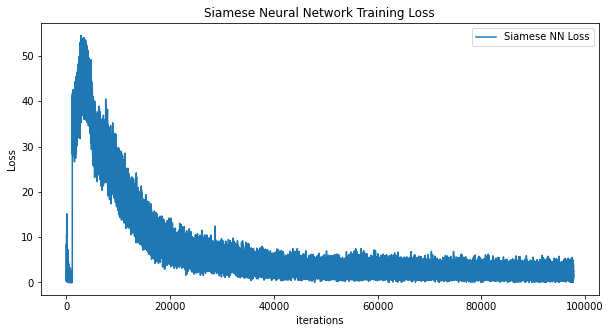

In [41]:
def plotTrainingLoss(S_losses):
    plt.figure(figsize=(10,5))
    plt.title("Siamese Neural Network Training Loss")
    plt.plot(S_losses,label="Siamese NN Loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
plotTrainingLoss(S_losses)

## Sample Performance

Below is plotted 8 pairs of fingerprints. Below each pair of fingerprints, the model will gives its prediction of whether each pair are of the same fingerprint or not. Below that is listed the ground truth.

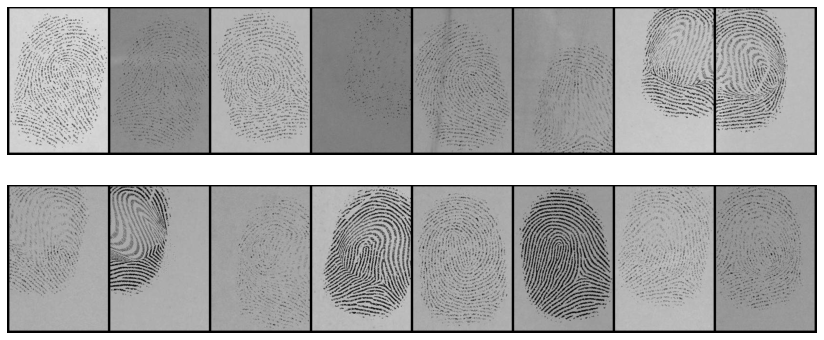

Pred: 
      diff           diff          diff          diff          diff           same          diff          same    

Truth:
      diff           diff          diff          diff          diff           same          diff          same    

Matching Accuracy over Test Dataset: 97.08%


In [42]:
def printLabels(labels):
    c = 0
    for l in labels:
        if l == 1:
            print("      same    ", end="")
        else:
            print("      diff    ", end="")
        if c % 4 == 0:
            print(" ", end="")
        c += 1
    print("\n")
    
    
def test(netS, loader, device):
    # Validate
    netS.eval()
    validation_accuracy = 0.0
    num_valid_correct = 0
    total_valid = 0
    for i, (x1, x2, y) in enumerate(loader): 
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        output = netS(x1, x2).view(-1)
        y = y.view(-1)

        for i in range(len(output)):
            label = 0.0
            if output[i] > 0.5:
                label = 1.0
            if label == y[i]:
                num_valid_correct += 1
            total_valid += 1

    validation_accuracy = num_valid_correct / total_valid * 100
    print("Matching Accuracy over Test Dataset: {:.2f}%".format(validation_accuracy))
    

def showTestPerformance(netS, test_loader, device):
    batch = next(iter(test_loader))
    labels = batch[2][:8]

    # Let model make predictions
    netS.eval()
    output = netS(batch[0].to(device)[:8], batch[1].to(device)[:8]).view(-1)

    # Display the Sample Images
    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(2,1,2)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.show()


    # Display Model Performance
    preds = [0 if x < 0.5 else 1 for x in output]

    print("Pred: ")
    printLabels(preds)

    print("Truth:")
    printLabels(labels)  
    
    test(netS, test_loader, device)
    
showTestPerformance(netS, test_loader, device)


## Conclusion

Better performance of the Fingerprint Siamese Neural Network was achieved by increasing the number of channels per layer. It was able to achieve a Testing Accuracy of 97%, and it was able to consistenly achieve a validateion accuracy of over 96% for the last 80 epochs of training. Although the model had to be trained for much longer than the previous version, the increased size of the network seemed to help avoid overfitting since the validation accuracy was consistenly similar to that of the training accuracy. In addition, the model achieved a testing accuracy that was higher than the training accuracy from the previous epoch, so it was able to generalize the information it learned from training. 

One limitation of this model is that it may have been able to exploit some artifact found in the synthetically generated fingerprints. Only testing this model on a dataset of real fingerprints would tell for sure though.